# Part 4: Introduction to Machine Learning

We're going to build a machine learning model using the classic Titanic dataset. A fill-in-the-blank version of this notebook is also available on [Google Colab](https://colab.research.google.com/drive/1NQ63sAnxuaE1teAslFebNxYZGHBNyOeL).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment', None)

### Loading the Data

<img src="https://s3.us-east-2.amazonaws.com/hidden.layers.assets/pythonseries/titanic_sinking.png" width="20%" align="right"/>

In this tutorial, we're going to be using the [Titanic dataset](https://www.kaggle.com/c/titanic/data) which is publicly available on Kaggle. Our goal will be to build a machine learning model that predicts which passengers survived the Titanic. 

The "label" in our dataset is `Survival` - it's what we want to predict in our model. When we train our model, we want to be able to find patterns in our features that can be used to predict whether a passenger survived.

Here's a data dictionary that maps out what each column name represents:

|Variable|Definition|Key|
|-------|----------|-----|
|Survival|whether the passenger survived (our label)|0=No,1=Yes|
|Pclass|ticket class|1=1st class, 2=2nd class, 3=3rd class|
|Sex|sex of the passenger| |
|Age|age of the passenger (in years)| |
|SibSp|number of siblings/spouses aboard the Titanic| |
|Parch|number of parents/children aboard the Titanic| |
|Ticket|ticket number| |
|Fare|cost of ticket| |
|Cabin|cabin number| |
|Embarked|port of embarkation|C=Cherbourg, Q=Queenstown, S=Southampton|

Let's load in our Titanic dataset from the cloud and take a peek at the type of data that we're working with.

In [2]:
titanic_data = pd.read_csv("https://s3.us-east-2.amazonaws.com/explore.datasets/rbi/titanic_train.csv")
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


How many columns and rows are in our dataset?

In [3]:
titanic_data.shape

(891, 12)

What are the datatypes of the columns?

In [4]:
titanic_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### Assessing Missing Values

Do we have any missing values in our dataset? 

In [5]:
titanic_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

It appears that `Age`, `Cabin`, and `Embarked` are the only columns that have missing values. The `Cabin` column has a significant amount of missing values (77%) while `Age` has fewer missing values (20%). 

### What proportion of passengers survived?

Of the passengers in this dataset, what proportion survived the shipwreck?

In [6]:
titanic_data['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

Only 38% of passengers survived the shipwreck.

### What was the age distribution?

Mean age was 29.7


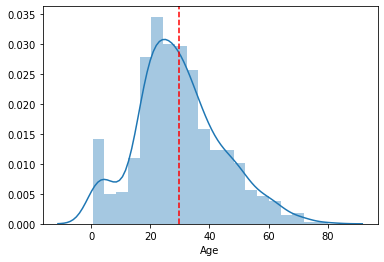

In [7]:
mean_age = titanic_data['Age'].mean()
print(f"Mean age was {round(mean_age,2)}")

sns.distplot(titanic_data['Age'].dropna())
plt.axvline(mean_age, color='red', linestyle='--')

The average age of a passenger on board the Titanic was 29.7 years old. The mean is represented as a red dotted line in the plot above.

### What was the male-female ratio? 

What proportion of passengers were male vs. female?

In [8]:
titanic_data['Sex'].value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

The male-female ratio was ~65:35. Passengers were predominantly male.

### What was the distribution in ticket prices?

Was there a large disparity between the most and least expensive tickets?

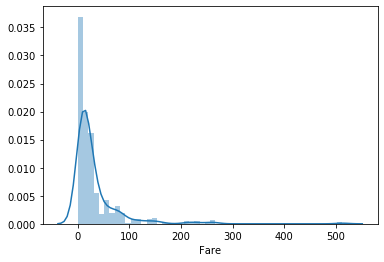

In [9]:
sns.distplot(titanic_data['Fare'])

In [10]:
min_fare = titanic_data['Fare'].min()
max_fare = titanic_data['Fare'].max()
mean_fare = titanic_data['Fare'].mean()

print(f"The lowest fare was {min_fare}.")
print(f"The highest fare was {round(max_fare,2)}.")
print(f"The mean fare was {round(mean_fare,2)}.")

The lowest fare was 0.0.
The highest fare was 512.33.
The mean fare was 32.2.


There is a large disparity in fare price, but it appears that a large proportion of tickets cost under 50 dollars.

### What's the distribution in passenger class?

`Pclass` is a column that represents the class of a ticket. Did the passenger stay in first class, second class or third class? Which class contained the most passengers?

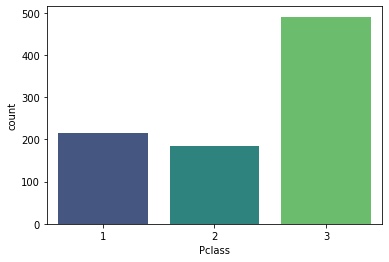

In [11]:
sns.countplot(titanic_data['Pclass'], palette='viridis')

In [12]:
titanic_data['Pclass'].value_counts(normalize=True)

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

More than half of the passengers were in third class, which may explain why a large proportion of tickets cost under 50 dollars. We can confirm this by grouping by `Pclass` and seeing what the average fare was for each class.

In [13]:
titanic_data.groupby('Pclass')['Fare'].mean().reset_index()

,Pclass,Fare
0,1,84.154687
1,2,20.662183
2,3,13.675550


The output above confirms that third class tickets cost the least (mean of \\$13) while the first class tickets cost the most (mean of \\$84).

### Data Pre-processing

Before we start training our machine learning (ML) model, we need to do some data pre-processing to get our data in the appropriate format. 

Which features do we want to include in our model? 

In [14]:
titanic_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

To keep our model simple, let's use 6 features for our initial model:

- `Pclass`
- `Sex`
- `Age`
- `SibSp`
- `Parch`
- `Fare`

In [15]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']

Most ML models aren't able to handle missing values, so we'll need to deal with these now. We're going to be including `Age` as a feature of our model, which contains missing values. There are several things that we can do to handle this. Some approaches involve complex imputation. For the purpose of this tutorial, we're going to handle this missingness problem by simply dropping all rows where `Age` is missing.

In [16]:
print(f"Shape before dropping missing values: {titanic_data.shape}")

titanic_data = titanic_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']].dropna()

print(f"Shape after dropping missing values: {titanic_data.shape}")

Shape before dropping missing values: (891, 12)
Shape after dropping missing values: (714, 7)


By tradition, the data containing the features is called `X` (upper case) and the data containing the "label" is `y` (lower case). Let's create new dataframes that represent our `X` and `y` data.

In [17]:
X = titanic_data[features]
y = titanic_data['Survived']

By dropping missing values, we went from 891 to 714 rows.

Another thing that we'll need to update is our `Sex` column. ML models typically don't accept categorical variables containing strings. `Sex` is currently represented by "male" and "female". We'll need to convert these values to 0 and 1 in order for our model to work properly.

In [18]:
X['Sex'] = X['Sex'].map({'female': 0, 'male': 1})

Great! Our `X` dataset is now ready for model training. 

### Choosing a Model

When building a binary classification model, there are a wide selection of machine learning models to choose from:

- Random Forest Classification
- Logistic Regression
- Linear Discriminant Analysis
- Support Vector Machines (SVM)
- Gaussian Naive Bayes
- k-Nearest Neighbours

We’ll test out the [Random Forest Classifier (RFC)](https://towardsdatascience.com/understanding-random-forest-58381e0602d2) for this dataset. RFC is an ensemble learning technique that works by creating a "forest" of decision trees. Each tree evaluates the data for a given passenger and outputs a 0 or 1. Random Forest looks at the output of all trees and gives the majority vote as its result. Let’s say we have a forest with 3 trees and 2 of them predict the passenger will be survive. The majority vote is that the passenger will survive. The probability of the passenger surviving is 2/3 (or ~66.7%).

<img src="https://s3.us-east-2.amazonaws.com/hidden.layers.assets/pythonseries/random_forest.png" width="50%"/>

We’re choosing Random Forest because:

- it is robust to outliers
- it is able to handle unbalanced datasets
- it measures feature importance

We’ll import RFC from [scikit-learn](https://scikit-learn.org) which is a very comprehensive Python library for data mining and data analysis.

In [19]:
from sklearn.ensemble import RandomForestClassifier

We can inspect the default parameters for RandomForestClassifier by creating an instance of the class and applying `get_params()`:

In [20]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

You can keep the default values for most of these parameters. But there are a few that can be modified prior to training the model that can impact model performance. These are called [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)). Some RFC hyperparameters include:

- `n_estimators`: number of trees in the forest
- `max_depth`: maximum number of levels in each decision tree
- `max_features`: maximum number of features considered for splitting a node
- `min_samples_split`: number of data points placed in a node before the node is split

These are external configurations that can’t be learned from training the model. To select the optimal values of a hyperparameter, we’ll need to use a technique called hyperparameter tuning.

### Hyperparameter Tuning 

Hyperparemter tuning is a critical step in the machine learning pipeline. It describes the process of choosing a set of optimal hyperparameters for a model. The hyperparameters that you select can have a significant impact on your model's performance. 

We're going to be testing out [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) offered by scikit-learn.


<img src="https://s3.us-east-2.amazonaws.com/hidden.layers.assets/grid_search.png" align="right" width="20%"/>

With grid search, you define your search space as a grid of values and iterate over each grid point until you find the optimal combination of values. Let's say we want to tune `max_depth` and `n_estimators` in our RandomForestClassifer. We'll set our search space as follows:

- n_estimators = [5,10,50]
- max_depth = [3,5,10]

This means that we'll have to train our model 9 times to test for every configuration of values. We'll choose the combination of n_estimators and max_depth that give us the best model performance.

Let's implement this with scikit-learn's GridSearchCV. We first need to define our search space as a dictionary. We also need to initialize our model.

In [21]:
from sklearn.model_selection import GridSearchCV

search_space = {
    'n_estimators': [5,10,50],
    'max_depth': [3,5,10]
}

rfc = RandomForestClassifier(random_state=416)

Now, we set up grid search. GridSearchCV also performs [cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/) (hence the "CV") so we can specify how many folds we want in our analysis. We'll set our number of folds to 3. The more folds you use, the longer it will take to compute results.

In [22]:
grid_search = GridSearchCV(rfc, search_space, cv=3)

The last step is to run fit. We'll pass in X and y which we created in our *Data Pre-Processing* step. GridSearchCV will use RFC's default metric, [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.score). If we want to optimize our model using another metric, we can specify `scoring = 'precision'` (or whichever metric we're interested in) inside GridSearchCV. Let's stick with accuracy for now.

In [23]:
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=416,
                                 

What are the optimal hyperparameters?

In [24]:
print(f"Optimal hyperparameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.3f}")

Optimal hyperparameters: {'max_depth': 10, 'n_estimators': 50}
Best score: 0.818


Based on the search space we defined for GridSearchCv, it looks like max_depth of 10 and n_estimators of 50 are our optimal hyperparmeters which gave us an accuracy of 0.818. Note: when you run this on your own, you might get a different score because there's a randomness component in `RandomForestClassifier`. To keep the randomness fixed, you can set the `random_state` parameter to a number of your choosing. 

We can also see a thorough report of our results with `cv_results_`. It shows fit time, score time, and mean train/test score (averaged over all folds). We'll sort by `mean_test_score`.

In [25]:
results = pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,0.058491,0.001264,0.005009,0.000125,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.777311,0.827731,0.848739,0.817927,0.029973,1
2,0.053553,0.000782,0.004507,0.000135,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.802521,0.827731,0.806723,0.812325,0.011028,2
1,0.012405,0.000280,0.001707,0.000013,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.794118,0.794118,0.810924,0.799720,0.007923,3
7,0.013185,0.000151,0.001775,0.000003,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.760504,0.802521,0.827731,0.796919,0.027730,4
4,0.012509,0.000461,0.001676,0.000002,5,10,"{'max_depth': 5, 'n_estimators': 10}",0.739496,0.819328,0.819328,0.792717,0.037633,5


### Evaluating Model Performance

There are several metrics that we can use to evaluate model performance:

- accuracy
- precision
- recall
- F1-score
- ROC AUC score

A comprehensive list of classification metrics can be found in scikit-learn's metrics module [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics). 

In this walkthrough, we'll look at `accuracy`, `precision`, and `recall`. But before we can start evaluating our model, let's split our data into two parts: 1) a training set and 2) a test set. We'll fit our model on the training data, and evaluate its performance using the test set.

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rfc = RandomForestClassifier(**grid_search.best_params_, random_state=416)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=416,
                       verbose=0, warm_start=False)

Accuracy is RFC's default evaluation metric. Using the score metric, we get the measured accuracy from the trained model. 

In [27]:
accuracy = rfc.score(X_test, y_test)

print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.853


An accuracy score of 0.853 means that ~85% of passengers were correctly labeled. The dataset that we're working with is relatively balanced, but let's say we have an imbalanced dataset where 90% of passengers ended up surviving. Using accuracy to evaluate a model trained on imbalanced data is a problem because if we automatically predicted all passengers to survive, our accuracy would be 90% by default. Precision and recall are better ways to evaluate performance of models trained on imbalanced data. 


#### Precision and Recall 

Precision and recall are information retrieval metrics that evaluate classification models. 

- [Precision](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall) is the "fraction of relevant instances among the retrieved instances".
    - What proportion of predicted surviving passengers actually survived?
- [Recall](https://en.wikipedia.org/wiki/Precision_and_recall#Recall) is the "fraction of the total amount of relevant instances that were actually retrieved".
    - What proportion of passengers that actually survived were identified correctly?

Looking at the equations below, we can see that precision aims to minimize the number of **False Positives**, while recall aims to minimize the number of **False Negatives**.

<img src="https://s3.us-east-2.amazonaws.com/hidden.layers.assets/precision_recall.png" width="70%"/>

In [29]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

y_pred = rfc.predict(X_test)

precision = precision_score(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

Precision: 0.826
Recall: 0.745


- Of the passengers who were labelled as survived, 82.6% actually survived.
- Of the passengers who actually survived, 74.5% were labelled as "survived". 

Another way to assess our model's performance is to visualize our results with a [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix).

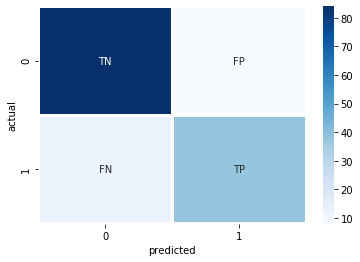

In [30]:
import numpy as np

confusion = confusion_matrix(y_true=y_test, y_pred=y_pred)
labels = np.array([['TN','FP'],['FN','TP']])

sns.heatmap(confusion,annot=labels, fmt='', linewidths=2, cmap="Blues")
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()

The heatmap above shows that we have a high True Negative rate (dark blue) and relatively low False Negative and False Positive rates (light blue). This means that when we predict a passenger will die, there's a good chance that we got it right.

### Evaluating Feature Importance

With `RandomForestClassifier`, we can dig further to examine which features were the most important in classification.

In [31]:
feature_importances = {
    'features': list(X.columns.values),
    'importance': list(rfc.feature_importances_)
}

important_features = pd.DataFrame(feature_importances)
important_features.sort_values(by='importance', ascending=False).head(15)

,features,importance
1,Sex,0.281708
5,Fare,0.266160
2,Age,0.259700
0,Pclass,0.105571
3,SibSp,0.046757
4,Parch,0.040104


The most important feautures appear to be `Sex`, `Fare`, and `Age`.